In [5]:
import cv2
import glob
import os
from sklearn.cluster import KMeans
import numpy as np
from cv2 import cvtColor
from PIL import Image
from skimage.color import rgb2gray

In [6]:
img_dir = './dog_and_cat/'
img_paths = glob.glob(os.path.join(img_dir,'*.jpg'))
bgr_images = []
gray_images = []
for img_path in img_paths:
    print(img_path)
    bgr_img = cv2.imread(img_path)
    gray_img = cvtColor(bgr_img,cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)
    bgr_images.append(bgr_img)

./dog_and_cat/Bản sao của 8.jpg
./dog_and_cat/Bản sao của 65.jpg
./dog_and_cat/Bản sao của 95(1).jpg
./dog_and_cat/Bản sao của 39(1).jpg
./dog_and_cat/Bản sao của 72.jpg
./dog_and_cat/Bản sao của 82(1).jpg
./dog_and_cat/Bản sao của 1.jpg
./dog_and_cat/Bản sao của 76(1).jpg
./dog_and_cat/Bản sao của 43.jpg
./dog_and_cat/Bản sao của 83(1).jpg
./dog_and_cat/Bản sao của 84(1).jpg
./dog_and_cat/Bản sao của 73.jpg
./dog_and_cat/Bản sao của 12.jpg
./dog_and_cat/Bản sao của 23(1).jpg
./dog_and_cat/Bản sao của 26(1).jpg
./dog_and_cat/Bản sao của 13(1).jpg
./dog_and_cat/Bản sao của 92(1).jpg
./dog_and_cat/Bản sao của 36(1).jpg
./dog_and_cat/Bản sao của 94.jpg
./dog_and_cat/Bản sao của 62.jpg
./dog_and_cat/Bản sao của 91.jpg
./dog_and_cat/Bản sao của 1(1).jpg
./dog_and_cat/Bản sao của 50(1).jpg
./dog_and_cat/Bản sao của 61.jpg
./dog_and_cat/Bản sao của 93(1).jpg
./dog_and_cat/Bản sao của 87.jpg
./dog_and_cat/Bản sao của 74.jpg
./dog_and_cat/Bản sao của 41.jpg
./dog_and_cat/Bản sao của 78(1).jpg
.

In [7]:
for image in img_paths:
    bgr_img = Image.open(image)
    bgr_img = bgr_img.resize((127,127))
    bgr_img = np.array(bgr_img)
    gray_images.append(gray_img)
    bgr_images.append(bgr_img)

In [8]:
img = cv2.imread('./dog_and_cat/Bản sao của 0.jpg')
img = img.resize((127,89))
sift = cv2.SIFT_create()
kp = sift.detect(gray_img,None)
img = cv2.drawKeypoints(gray_img,kp,img)

In [9]:
img_descriptors = []
img_keypoint = []
sift = cv2.SIFT_create()
for gray in gray_images:
    kp,dsc = sift.detectAndCompute(gray,None)
    if dsc is not None:
        img_descriptors.append(dsc)
        img_keypoint.append(kp)
    

In [10]:
print("number of images: ",len(gray_images))
print("number of used images: ", len(img_descriptors) )

number of images:  402
number of used images:  402


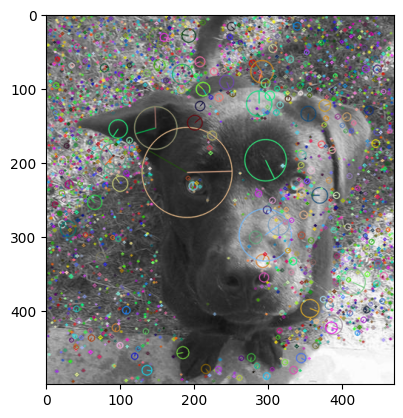

In [11]:

from matplotlib import pyplot as plt


img = cv2.drawKeypoints(gray_images[0],
                        img_keypoint[0],
                        bgr_images[0],
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

In [12]:
KeyPoint_total = 0
for kp in img_keypoint:
    KeyPoint_total += len(kp)
print("number of keypoints (all images): ",KeyPoint_total)

number of keypoints (all images):  570714


In [13]:
# Tạo tập dữ liệu (data points)
X = []
for img_desc in img_descriptors:
    X += list(img_desc)
print(len(X))

X_np = np.asarray(X)
print(X_np.shape)

570714
(570714, 128)


In [14]:
print(X_np)

[[144. 144.   0. ...   0.   2.  12.]
 [  3.   0.   0. ...   0.   0.   2.]
 [  9.  19.  51. ...   0.   0.   0.]
 ...
 [  6.   6.  17. ...   1.   3.  13.]
 [ 12.  18.  18. ...   3.   3.   9.]
 [ 20.  42.   8. ...   8.  14.   7.]]


# K-MEANS

In [15]:
# Thực hiện phân cụm
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_np)

In [16]:
# Save my codebook
import joblib
codebook = kmeans
joblib.dump(codebook, './codebook_200.pkl')

['./codebook_200.pkl']

In [17]:
codebook.labels_

array([0, 1, 2, ..., 3, 3, 3], dtype=int32)

In [18]:
codebook = codebook.cluster_centers_

In [19]:
from scipy.cluster.vq import vq

# Lặp qua mỗi ảnh
img_visual_words = []
for img_desc in img_descriptors:
    img_vw = vq(img_desc, codebook)
    img_visual_words.append(img_vw[0])
# print(img_visual_words[0])

In [20]:
import numpy as np

num_visual_words = 50

img_histograms = []
for img_vw in img_visual_words:
    histo = np.zeros((1,num_visual_words))
    for vw_idx in img_vw:
        histo[0,vw_idx] += 1
    img_histograms.append(histo[0])

50


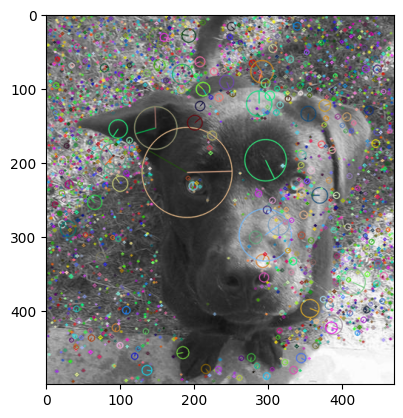

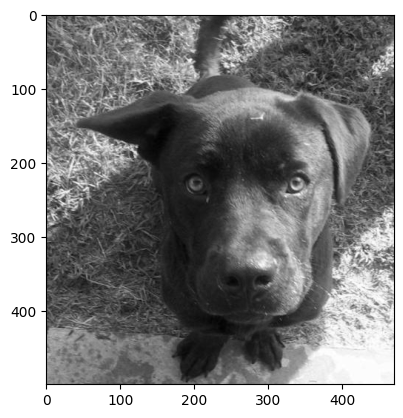

In [21]:
search_idx = 0
search_bgr_image = bgr_images[search_idx]
search_gray_image = gray_images[search_idx]
plt.figure(0)
plt.imshow(search_bgr_image)
plt.figure(1)
plt.imshow(search_gray_image, cmap='gray')

search_histogram = img_histograms[search_idx]
print(len(search_histogram))

In [22]:
def euclidean_distance(fv1, fv2):
    return np.sqrt(np.sum((fv1-fv2)*(fv1-fv2)))

def distance_matrix(fv, set_of_fv):
    mat = []
    for x in set_of_fv:
        d = euclidean_distance(fv, x)
        mat.append(d)
    return np.array(mat)

fv = search_histogram

mat = distance_matrix(fv, img_histograms)
# print(mat)

In [23]:
top_k = 10
ret_idx = np.argsort(mat)[:top_k]
print(ret_idx)

[  0  94  77 137 106 121  99 151 128  42]


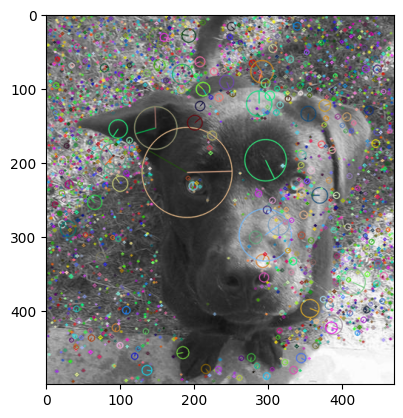

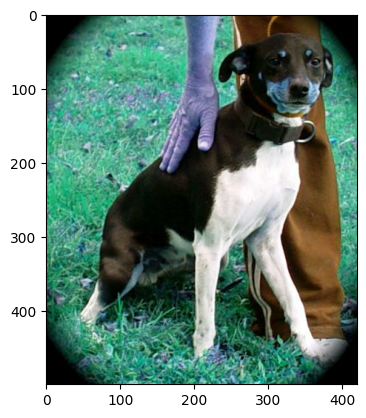

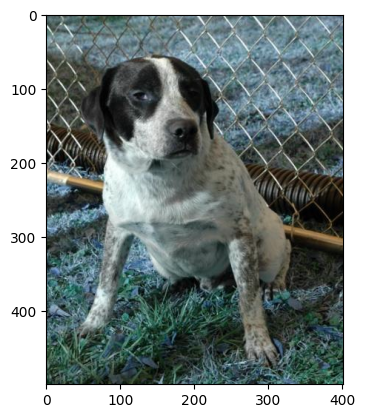

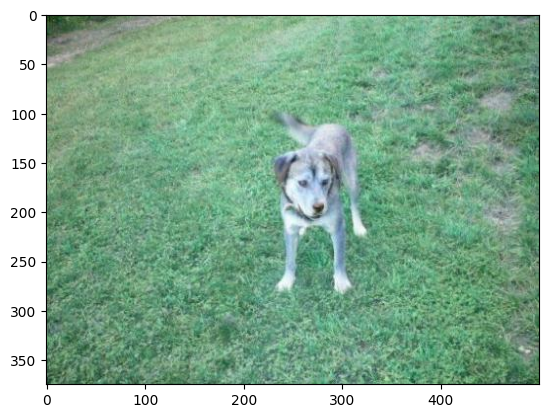

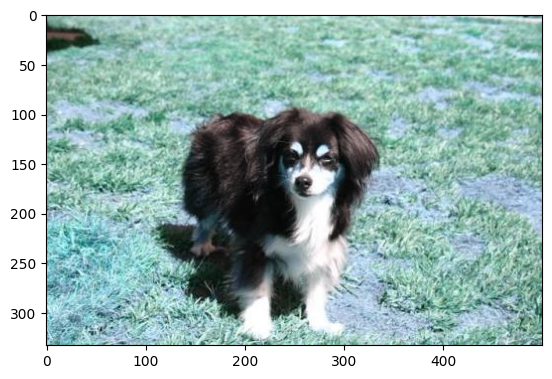

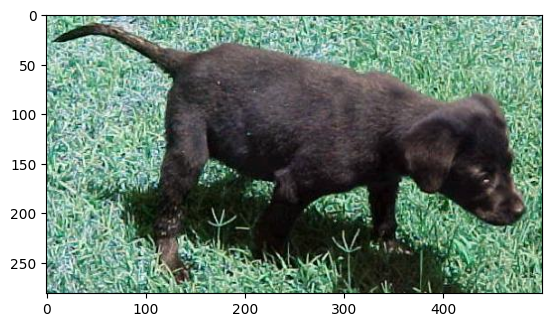

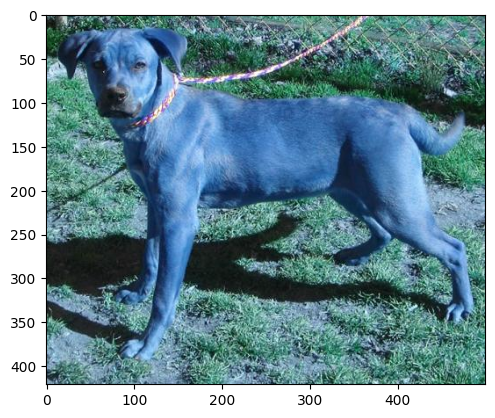

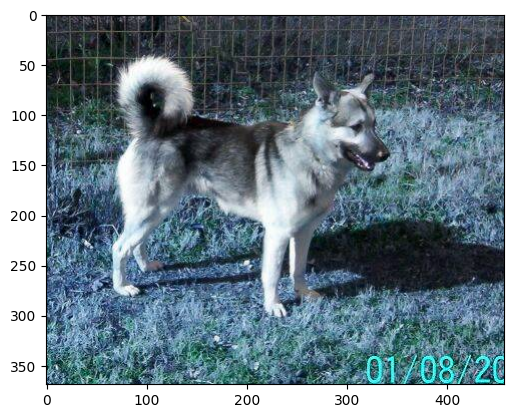

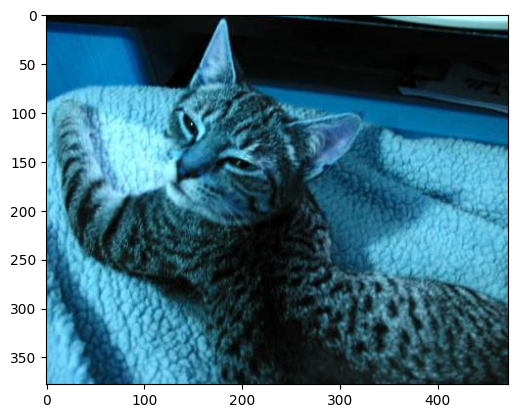

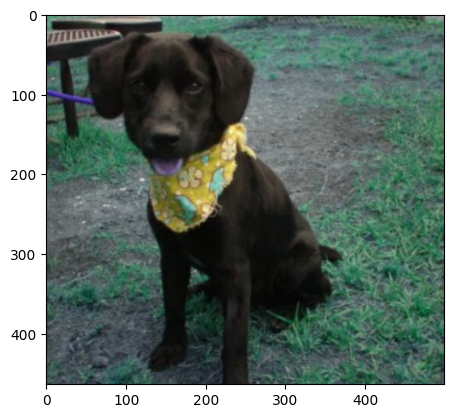

In [24]:
for idx in ret_idx:
    img = bgr_images[idx]
    plt.figure()
    plt.imshow(img)

# K-MEDOIDS

In [25]:
from scipy.cluster.vq import kmeans2
from scipy.spatial.distance import cdist

In [26]:
def k_medoids(X,k,tmax=100):
    #randomly initialize an array of medoid indices
    M = np.random.choice(len(X),k)
    #create a copy of the array of medoids indices
    Mnew = np.copy(M)
    #initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        #determine cluster,i. e. arrays of data indices
        J = np.argmin(cdist(X,X[M]),axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J == kappa)[0]
        for kappa in range(k):
            J = np.mean(cdist(X, X[C[kappa]]), axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
            #check for convergence
        if np.array_equal(M,Mnew):
            break
        M = np.copy(Mnew)
    else:
            #final update of cluster memberships
        J = np.argmin(cdist(X,X[M]),axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J == kappa)[0]
    #return results
    return M,C

In [ ]:
k_medoids_centers,K_medoids_clusters  = k_medoids(X_np,k)

In [ ]:
codebook_1 = k_medoids_centers
joblib.dump(codebook_1,'./codebook_200_medoids.pkl')

In [ ]:
# Lặp qua mỗi ảnh
img_visual_words_kmd = []
for img_desc in img_descriptors:
    img_vw = vq(img_desc, codebook_1)
    img_visual_words_kmd.append(img_vw[0])

In [ ]:

img_histograms_kmd = []
for img_vw in img_visual_words_kmd:
    histo = np.zeros((1,num_visual_words))
    for vw_idx in img_vw:
        histo[0,vw_idx] += 1
    img_histograms.append(histo[0])

In [ ]:
search_idx_kmd = 0
search_bgr_image_kmd = bgr_images[search_idx_kmd]
search_gray_image_kmd = gray_images[search_idx_kmd]
plt.figure(0)
plt.imshow(search_bgr_image_kmd)
plt.figure(1)
plt.imshow(search_gray_image_kmd, cmap='gray')

search_histogram_kmd = img_histograms_kmd[search_idx_kmd]
print(len(search_histogram_kmd))

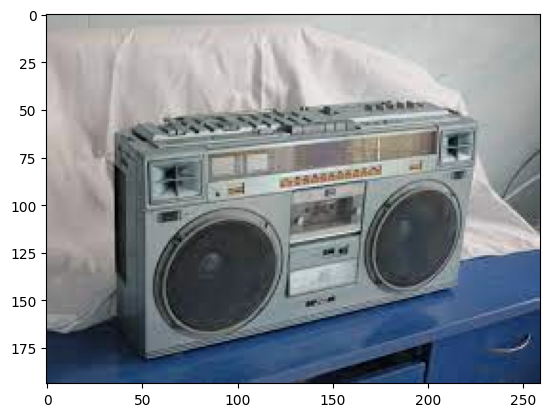

In [ ]:
import cv2

# Đọc ảnh
bgr_img = cv2.imread('test_1.jpeg')
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
plt.imshow(bgr_img)

In [ ]:
# Trích xuất visual features (SIFT)
extractor = cv2.SIFT_create()
keypoints, descriptors = extractor.detectAndCompute(gray_img, None)

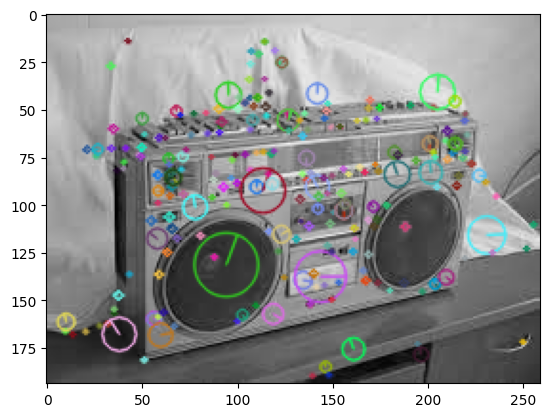

In [ ]:
# Visualize SIFT features
img = cv2.drawKeypoints(gray_img,
                        keypoints,
                        bgr_img,
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

In [ ]:
# Vector Quantizatiton and Image Representation
from scipy.cluster.vq import vq

num_visual_words = 50

vw_map = vq(descriptors, codebook)[0]

histo = np.zeros((1,num_visual_words))
for idx in vw_map:
    histo[0,idx] += 1
fv = histo[0]

print(fv)

[21. 16. 31. 39. 18. 32. 42. 36. 19. 20.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [ ]:
# Search
mat = distance_matrix(fv, img_histograms)
top_k = 10
ret = np.argsort(mat)[:top_k]
print(ret)

[158 118 165  67  71  26  52 189   8  72]


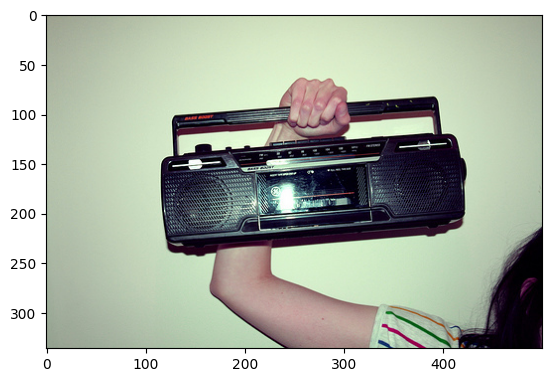

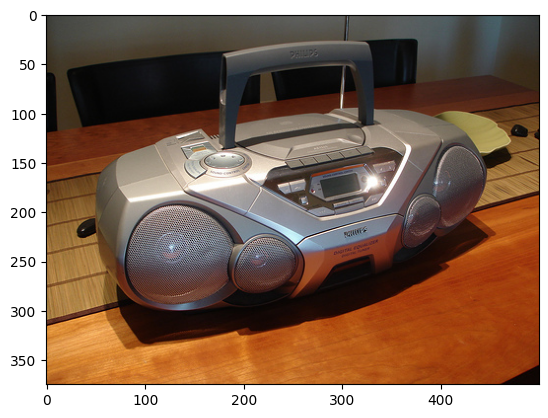

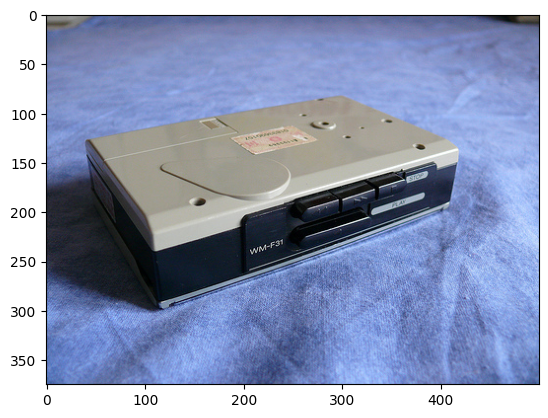

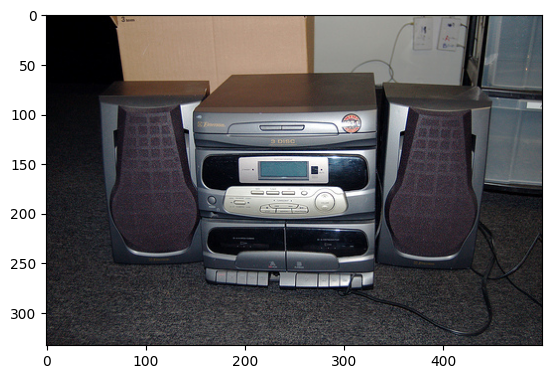

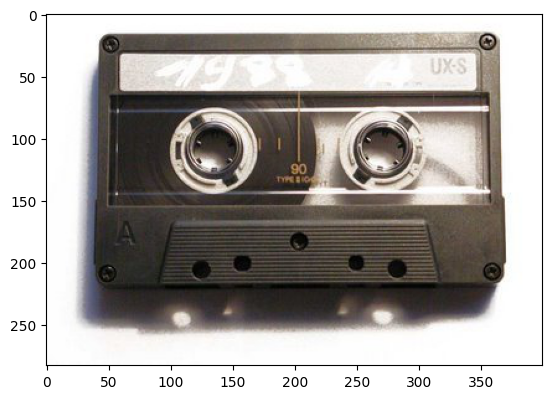

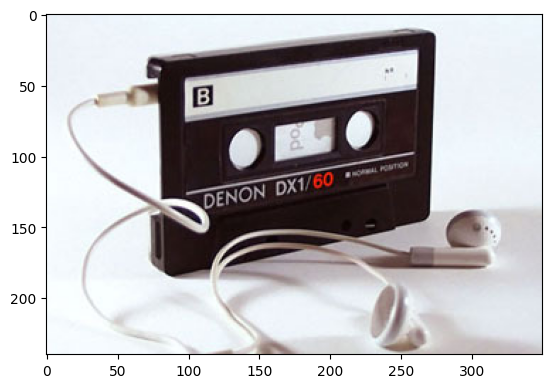

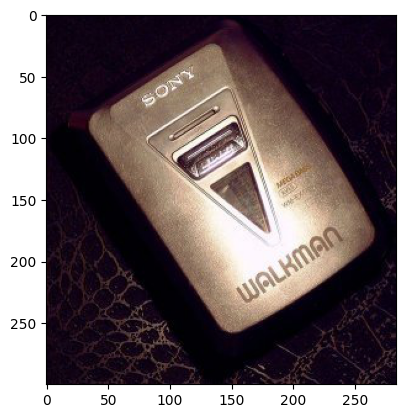

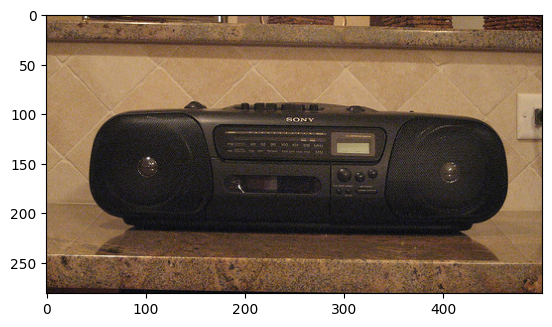

In [ ]:
for idx in ret:
    img = bgr_images[idx]
    plt.figure()
    plt.imshow(img)